In [1]:

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import datetime
import tensorflow_addons as tfa

Positional Embedding added

In [2]:
from sklearn.decomposition import PCA  # to apply PCA

In [3]:
#Registering start time of the experiment
#logging date and time
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")

In [4]:
current_time=current_time.replace(" ", "_")

In [5]:
current_time=current_time.replace(":", "_")

In [6]:
current_time

'2023-07-13_03_16_06'

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
from keras.utils import timeseries_dataset_from_array

In [9]:
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)

In [10]:
#list all CPUs and GPUs
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9437292456730278653
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5711593472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12462354860351493156
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [11]:
import pickle

#path = "C:\\Users\\MalakAlmarshad\\Desktop\\premirly dataset for experiment\\ICUecgtiny.pkl"#for part of the dataset

path = "C:\\Users\\MalakAlmarshad\\Desktop\\premirly dataset for experiment\\ICUecgAll.pkl"



# Loading the dataset
with open(path, 'rb') as file:
    dataset = pickle.load(file)
    
display(dataset.head())

display(dataset.dtypes)

,patient,timestamp_datetime,SpO2(%),signal_ecg_ii,event,anomaly
0,1,2019-07-29 21:00:36,NaN,"[122, 121, 121, 120, 120, 122, 123, 124, 125, ...",NONE,False
1,1,2019-07-29 21:00:37,NaN,"[123, 124, 123, 123, 123, 122, 123, 123, 123, ...",NONE,False
2,1,2019-07-29 21:00:38,NaN,"[123, 124, 124, 124, 124, 124, 124, 124, 124, ...",NONE,False
3,1,2019-07-29 21:00:39,NaN,"[126, 126, 126, 126, 126, 125, 126, 126, 126, ...",NONE,False
4,1,2019-07-29 21:00:40,NaN,"[128, 127, 126, 125, 126, 127, 126, 125, 125, ...",NONE,False


patient                       object
timestamp_datetime    datetime64[ns]
SpO2(%)                      float64
signal_ecg_ii                 object
event                         object
anomaly                      boolean
dtype: object

In [12]:
dataframe = dataset
df = dataframe[['SpO2(%)', 'anomaly']]


<AxesSubplot: xlabel='SpO2(%)', ylabel='anomaly'>

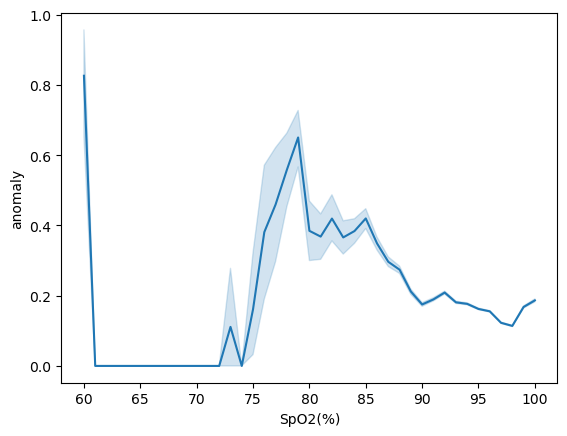

In [13]:

sns.lineplot(x=df['SpO2(%)'], y=df['anomaly'])

In [14]:
df

,SpO2(%),anomaly
0,NaN,False
1,NaN,False
2,NaN,False
3,NaN,False
4,NaN,False
...,...,...
961352,95.0,False
961353,95.0,False
961354,95.0,False
961355,95.0,False


In [15]:
df=df.dropna()

In [16]:
df

,SpO2(%),anomaly
2075,82.0,False
2076,82.0,False
2077,82.0,False
2078,82.0,False
2079,82.0,False
...,...,...
961352,95.0,False
961353,95.0,False
961354,95.0,False
961355,95.0,False


In [17]:
x = df[['SpO2(%)']]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = x_scaled

df['SpO2(%)']=dataset

C:\Users\MalakAlmarshad\AppData\Local\Temp\ipykernel_22128\2850543328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SpO2(%)']=dataset


In [18]:
df

,SpO2(%),anomaly
2075,0.550,False
2076,0.550,False
2077,0.550,False
2078,0.550,False
2079,0.550,False
...,...,...
961352,0.875,False
961353,0.875,False
961354,0.875,False
961355,0.875,False


Create sequences

In [19]:

sample_length = 360 #sequance length , AIOSA=180 , per sec
batch_size =64
# 1 beacause it's univariate
n_features = 1

sequence_length=sample_length
latent_dim = 2048
num_heads = 8#8
vocab_size = 15000#15000 Input
embed_dim = 256#256#less than vocab output


In [20]:
#Defining features (x) and labels (y)
targets = df["anomaly"]
input_data = df["SpO2(%)"]

In [21]:

def create_sequences(values, time_steps=sample_length):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [22]:
# df_training_value[10:]

In [23]:
input_data

2075      0.550
2076      0.550
2077      0.550
2078      0.550
2079      0.550
          ...  
961352    0.875
961353    0.875
961354    0.875
961355    0.875
961356    0.875
Name: SpO2(%), Length: 828777, dtype: float64

In [24]:
targets

2075      False
2076      False
2077      False
2078      False
2079      False
          ...  
961352    False
961353    False
961354    False
961355    False
961356    False
Name: anomaly, Length: 828777, dtype: boolean

In [25]:
#Encode categorical features as a one-hot numeric array.
le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(targets)
targets = le.transform(targets)

In [26]:
targets

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
d_model=1024

In [28]:
len(targets)

828777

In [29]:
name_classes = le.classes_

In [30]:
##count the names andbnumber of classes
n_classes= len(name_classes)

In [31]:
n_classes

2

In [32]:
input_data.head(11)

2075    0.550
2076    0.550
2077    0.550
2078    0.550
2079    0.550
2080    0.550
2081    0.550
2082    0.550
2083    0.550
2084    0.550
2085    0.675
Name: SpO2(%), dtype: float64

In [33]:
targets

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
x_seq=create_sequences(input_data)

C:\Users\MalakAlmarshad\AppData\Local\Temp\ipykernel_22128\948889072.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  output.append(values[i : (i + time_steps)])


In [35]:
y_seq=create_sequences(targets)

In [36]:
y_seq

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
x_seq

array([[0.55 , 0.55 , 0.55 , ..., 0.9  , 0.9  , 0.9  ],
       [0.55 , 0.55 , 0.55 , ..., 0.9  , 0.9  , 0.9  ],
       [0.55 , 0.55 , 0.55 , ..., 0.9  , 0.9  , 0.9  ],
       ...,
       [0.925, 0.925, 0.925, ..., 0.875, 0.875, 0.875],
       [0.925, 0.925, 0.925, ..., 0.875, 0.875, 0.875],
       [0.925, 0.925, 0.925, ..., 0.875, 0.875, 0.875]])

In [38]:
y_seq.shape

(828418, 360)

In [39]:
x_seq.shape

(828418, 360)

In [40]:
# y_seq = y_seq.reshape((y_seq.shape[0], y_seq.shape[1], 1))
x_seq = x_seq.reshape((x_seq.shape[0], x_seq.shape[1], 1))

In [41]:
x_seq.shape

(828418, 360, 1)

In [42]:
y_seq.shape

(828418, 360)

In [43]:
y_seq

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
x_seq

array([[[0.55 ],
        [0.55 ],
        [0.55 ],
        ...,
        [0.9  ],
        [0.9  ],
        [0.9  ]],

       [[0.55 ],
        [0.55 ],
        [0.55 ],
        ...,
        [0.9  ],
        [0.9  ],
        [0.9  ]],

       [[0.55 ],
        [0.55 ],
        [0.55 ],
        ...,
        [0.9  ],
        [0.9  ],
        [0.9  ]],

       ...,

       [[0.925],
        [0.925],
        [0.925],
        ...,
        [0.875],
        [0.875],
        [0.875]],

       [[0.925],
        [0.925],
        [0.925],
        ...,
        [0.875],
        [0.875],
        [0.875]],

       [[0.925],
        [0.925],
        [0.925],
        ...,
        [0.875],
        [0.875],
        [0.875]]])

In [45]:
df1 = (y_seq != 0).any(1).astype(int)
print (df1)

[0 0 0 ... 0 0 0]


In [46]:
df1.shape

(828418,)

In [47]:
y_seq=df1

In [48]:
y_seq

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
vals_dict = {}
for i in y_seq:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

{0: 0.5954506058535667, 1: 0.4045493941464333}


In [50]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_seq, y_seq, test_size=0.2, #shuffle=True #random_state=42, shuffle=True
)

In [51]:
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

In [52]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [53]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [54]:
def AutoEncoder(inputs):

    
    x= layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(inputs)
    x= layers.Dropout(rate=0.2)(x)
    x= layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x= layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x= layers.Dropout(rate=0.2)(x)
    x= layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x= layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    x= layers.Conv1D(filters=132, kernel_size=7, padding="same", strides=2, activation="relu")(inputs)
    x= layers.Dropout(rate=0.1)(x)
    x= layers.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x= layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    x= layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x= layers.Dropout(rate=0.2)(x)
    x= layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x= layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    return (x)

In [55]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [56]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    # AutoEncoder 
    x = AutoEncoder(inputs)
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [57]:
y_train.shape

(662734, 2)

In [58]:
# y_train=y_train.T.reshape(-1, 1)

In [59]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [60]:
y_train.shape

(662734, 2)

In [61]:
x_train.shape

(662734, 360, 1)

In [62]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,#4
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [63]:
# optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay = 0.0001)
optimizer = tf.optimizers.Adam(learning_rate=0.00001)

In [64]:
model.compile(optimizer=optimizer, loss="binary_crossentropy",weighted_metrics=["accuracy"])



In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 180, 132)     1056        ['input_1[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 180, 132)     0           ['conv1d_2[0][0]']               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 90, 64)       59200       ['dropout_2[0][0]']              
                                                                                              

 rmalization)                                                                                     
                                                                                                  
 conv1d_8 (Conv1D)              (None, 360, 4)       8           ['layer_normalization_5[0][0]']  
                                                                                                  
 dropout_9 (Dropout)            (None, 360, 4)       0           ['conv1d_8[0][0]']               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 360, 1)       5           ['dropout_9[0][0]']              
                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 360, 1)      0           ['conv1d_9[0][0]',               
 mbda)                                                            'tf.__operators__.add_4[0][0]'] 
          

In [66]:
#hing loss did not work in tiny dataset

model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,#1e-4
    weighted_metrics=["accuracy",
             #tf.keras.metrics.CategoricalAccuracy(),
             tf.keras.metrics.BinaryAccuracy(),
             tfa.metrics.F1Score(num_classes=2,average='micro',threshold=0.5),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.SpecificityAtSensitivity(0.5),
             tf.keras.metrics.SensitivityAtSpecificity(0.5),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.Precision(),
             ]
)

In [67]:
import os
log_dir= "logs/fit/" + current_time
#Save model folder name as a checkPoint
checkpoint_path = "training_model_4_SpO2_AE_360/cp.ckpt"

In [68]:
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=0.00000000000000,
    ), keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_best_only=True, monitor="val_loss"),     tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [69]:
#batch_size=64 is the maximum that my GPU can handle
history= model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200, #200
    batch_size=batch_size,#32
    callbacks=callbacks,
    #shuffle=True,
    class_weight=weight_dict,
)

Epoch 1/200
8285/8285 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.5131 - binary_accuracy: 0.5131 - f1_score: 0.5135 - auc: 0.5215 - specificity_at_sensitivity: 0.4291 - sensitivity_at_specificity: 0.4291 - recall: 0.5131 - precision: 0.5131

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1325s 159ms/step - loss: 0.3335 - accuracy: 0.5131 - binary_accuracy: 0.5131 - f1_score: 0.5135 - auc: 0.5215 - specificity_at_sensitivity: 0.4291 - sensitivity_at_specificity: 0.4291 - recall: 0.5131 - precision: 0.5131 - val_loss: 0.6906 - val_accuracy: 0.5307 - val_binary_accuracy: 0.5307 - val_f1_score: 0.5307 - val_auc: 0.5461 - val_specificity_at_sensitivity: 0.5504 - val_sensitivity_at_specificity: 0.5504 - val_recall: 0.5307 - val_precision: 0.5307 - lr: 1.0000e-05
Epoch 2/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.5788 - binary_accuracy: 0.5788 - f1_score: 0.5742 - auc: 0.6023 - specificity_at_sensitivity: 0.6475 - sensitivity_at_specificity: 0.6475 - recall: 0.5788 - precision: 0.5788

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1318s 159ms/step - loss: 0.3279 - accuracy: 0.5788 - binary_accuracy: 0.5788 - f1_score: 0.5742 - auc: 0.6023 - specificity_at_sensitivity: 0.6475 - sensitivity_at_specificity: 0.6475 - recall: 0.5788 - precision: 0.5788 - val_loss: 0.6686 - val_accuracy: 0.5820 - val_binary_accuracy: 0.5820 - val_f1_score: 0.5820 - val_auc: 0.6270 - val_specificity_at_sensitivity: 0.6772 - val_sensitivity_at_specificity: 0.6772 - val_recall: 0.5820 - val_precision: 0.5820 - lr: 1.0000e-05
Epoch 3/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.7042 - binary_accuracy: 0.7042 - f1_score: 0.6968 - auc: 0.7763 - specificity_at_sensitivity: 0.8522 - sensitivity_at_specificity: 0.8522 - recall: 0.7042 - precision: 0.7042

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1377s 166ms/step - loss: 0.2743 - accuracy: 0.7042 - binary_accuracy: 0.7042 - f1_score: 0.6968 - auc: 0.7763 - specificity_at_sensitivity: 0.8522 - sensitivity_at_specificity: 0.8522 - recall: 0.7042 - precision: 0.7042 - val_loss: 0.4493 - val_accuracy: 0.7783 - val_binary_accuracy: 0.7783 - val_f1_score: 0.7783 - val_auc: 0.8714 - val_specificity_at_sensitivity: 0.9525 - val_sensitivity_at_specificity: 0.9525 - val_recall: 0.7783 - val_precision: 0.7783 - lr: 1.0000e-05
Epoch 4/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.7812 - binary_accuracy: 0.7812 - f1_score: 0.7762 - auc: 0.8625 - specificity_at_sensitivity: 0.9389 - sensitivity_at_specificity: 0.9389 - recall: 0.7812 - precision: 0.7812

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1559s 188ms/step - loss: 0.2235 - accuracy: 0.7812 - binary_accuracy: 0.7812 - f1_score: 0.7762 - auc: 0.8625 - specificity_at_sensitivity: 0.9389 - sensitivity_at_specificity: 0.9389 - recall: 0.7812 - precision: 0.7812 - val_loss: 0.4201 - val_accuracy: 0.8013 - val_binary_accuracy: 0.8013 - val_f1_score: 0.8013 - val_auc: 0.8889 - val_specificity_at_sensitivity: 0.9577 - val_sensitivity_at_specificity: 0.9577 - val_recall: 0.8013 - val_precision: 0.8013 - lr: 1.0000e-05
Epoch 5/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2176 - accuracy: 0.7887 - binary_accuracy: 0.7887 - f1_score: 0.7854 - auc: 0.8705 - specificity_at_sensitivity: 0.9444 - sensitivity_at_specificity: 0.9444 - recall: 0.7887 - precision: 0.7887

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1605s 194ms/step - loss: 0.2176 - accuracy: 0.7887 - binary_accuracy: 0.7887 - f1_score: 0.7854 - auc: 0.8705 - specificity_at_sensitivity: 0.9444 - sensitivity_at_specificity: 0.9444 - recall: 0.7887 - precision: 0.7887 - val_loss: 0.4126 - val_accuracy: 0.8104 - val_binary_accuracy: 0.8104 - val_f1_score: 0.8104 - val_auc: 0.8931 - val_specificity_at_sensitivity: 0.9581 - val_sensitivity_at_specificity: 0.9581 - val_recall: 0.8104 - val_precision: 0.8104 - lr: 1.0000e-05
Epoch 6/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.7921 - binary_accuracy: 0.7921 - f1_score: 0.7901 - auc: 0.8745 - specificity_at_sensitivity: 0.9482 - sensitivity_at_specificity: 0.9482 - recall: 0.7921 - precision: 0.7921

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1639s 198ms/step - loss: 0.2144 - accuracy: 0.7921 - binary_accuracy: 0.7921 - f1_score: 0.7901 - auc: 0.8745 - specificity_at_sensitivity: 0.9482 - sensitivity_at_specificity: 0.9482 - recall: 0.7921 - precision: 0.7921 - val_loss: 0.4112 - val_accuracy: 0.8104 - val_binary_accuracy: 0.8104 - val_f1_score: 0.8104 - val_auc: 0.8940 - val_specificity_at_sensitivity: 0.9602 - val_sensitivity_at_specificity: 0.9602 - val_recall: 0.8104 - val_precision: 0.8104 - lr: 1.0000e-05
Epoch 7/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2121 - accuracy: 0.7946 - binary_accuracy: 0.7946 - f1_score: 0.7939 - auc: 0.8772 - specificity_at_sensitivity: 0.9494 - sensitivity_at_specificity: 0.9494 - recall: 0.7946 - precision: 0.7946

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1621s 196ms/step - loss: 0.2121 - accuracy: 0.7946 - binary_accuracy: 0.7946 - f1_score: 0.7939 - auc: 0.8772 - specificity_at_sensitivity: 0.9494 - sensitivity_at_specificity: 0.9494 - recall: 0.7946 - precision: 0.7946 - val_loss: 0.4084 - val_accuracy: 0.8118 - val_binary_accuracy: 0.8118 - val_f1_score: 0.8118 - val_auc: 0.8950 - val_specificity_at_sensitivity: 0.9593 - val_sensitivity_at_specificity: 0.9593 - val_recall: 0.8118 - val_precision: 0.8118 - lr: 1.0000e-05
Epoch 8/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.7964 - binary_accuracy: 0.7964 - f1_score: 0.7965 - auc: 0.8802 - specificity_at_sensitivity: 0.9511 - sensitivity_at_specificity: 0.9511 - recall: 0.7964 - precision: 0.7964

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1583s 191ms/step - loss: 0.2095 - accuracy: 0.7964 - binary_accuracy: 0.7964 - f1_score: 0.7965 - auc: 0.8802 - specificity_at_sensitivity: 0.9511 - sensitivity_at_specificity: 0.9511 - recall: 0.7964 - precision: 0.7964 - val_loss: 0.4060 - val_accuracy: 0.8118 - val_binary_accuracy: 0.8118 - val_f1_score: 0.8118 - val_auc: 0.8963 - val_specificity_at_sensitivity: 0.9613 - val_sensitivity_at_specificity: 0.9613 - val_recall: 0.8118 - val_precision: 0.8118 - lr: 1.0000e-05
Epoch 9/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2072 - accuracy: 0.7982 - binary_accuracy: 0.7982 - f1_score: 0.7986 - auc: 0.8827 - specificity_at_sensitivity: 0.9555 - sensitivity_at_specificity: 0.9555 - recall: 0.7982 - precision: 0.7982

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1587s 191ms/step - loss: 0.2072 - accuracy: 0.7982 - binary_accuracy: 0.7982 - f1_score: 0.7986 - auc: 0.8827 - specificity_at_sensitivity: 0.9555 - sensitivity_at_specificity: 0.9555 - recall: 0.7982 - precision: 0.7982 - val_loss: 0.4049 - val_accuracy: 0.8129 - val_binary_accuracy: 0.8129 - val_f1_score: 0.8129 - val_auc: 0.8968 - val_specificity_at_sensitivity: 0.9608 - val_sensitivity_at_specificity: 0.9608 - val_recall: 0.8129 - val_precision: 0.8129 - lr: 1.0000e-05
Epoch 10/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.7997 - binary_accuracy: 0.7997 - f1_score: 0.8000 - auc: 0.8846 - specificity_at_sensitivity: 0.9567 - sensitivity_at_specificity: 0.9567 - recall: 0.7997 - precision: 0.7997

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1521s 184ms/step - loss: 0.2053 - accuracy: 0.7997 - binary_accuracy: 0.7997 - f1_score: 0.8000 - auc: 0.8847 - specificity_at_sensitivity: 0.9567 - sensitivity_at_specificity: 0.9567 - recall: 0.7997 - precision: 0.7997 - val_loss: 0.4007 - val_accuracy: 0.8136 - val_binary_accuracy: 0.8136 - val_f1_score: 0.8136 - val_auc: 0.8987 - val_specificity_at_sensitivity: 0.9650 - val_sensitivity_at_specificity: 0.9650 - val_recall: 0.8136 - val_precision: 0.8136 - lr: 1.0000e-05
Epoch 11/200
8285/8285 [==============================] - 1499s 181ms/step - loss: 0.2035 - accuracy: 0.8008 - binary_accuracy: 0.8008 - f1_score: 0.8009 - auc: 0.8866 - specificity_at_sensitivity: 0.9581 - sensitivity_at_specificity: 0.9581 - recall: 0.8008 - precision: 0.8008 - val_loss: 0.4053 - val_accuracy: 0.8125 - val_binary_accuracy: 0.8125 - val_f1_score: 0.8125 - val_auc: 0.8963 - val_specificity_at_sensitivity: 0.9610 - val_sensitivity_at_specificity: 0.9610 - v

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1496s 181ms/step - loss: 0.2023 - accuracy: 0.8020 - binary_accuracy: 0.8020 - f1_score: 0.8020 - auc: 0.8879 - specificity_at_sensitivity: 0.9591 - sensitivity_at_specificity: 0.9591 - recall: 0.8020 - precision: 0.8020 - val_loss: 0.3992 - val_accuracy: 0.8172 - val_binary_accuracy: 0.8172 - val_f1_score: 0.8172 - val_auc: 0.8995 - val_specificity_at_sensitivity: 0.9642 - val_sensitivity_at_specificity: 0.9642 - val_recall: 0.8172 - val_precision: 0.8172 - lr: 1.0000e-05
Epoch 13/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.2009 - accuracy: 0.8034 - binary_accuracy: 0.8034 - f1_score: 0.8035 - auc: 0.8894 - specificity_at_sensitivity: 0.9601 - sensitivity_at_specificity: 0.9601 - recall: 0.8034 - precision: 0.8034

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1497s 181ms/step - loss: 0.2009 - accuracy: 0.8034 - binary_accuracy: 0.8034 - f1_score: 0.8035 - auc: 0.8894 - specificity_at_sensitivity: 0.9601 - sensitivity_at_specificity: 0.9601 - recall: 0.8034 - precision: 0.8034 - val_loss: 0.3985 - val_accuracy: 0.8118 - val_binary_accuracy: 0.8118 - val_f1_score: 0.8118 - val_auc: 0.8995 - val_specificity_at_sensitivity: 0.9663 - val_sensitivity_at_specificity: 0.9663 - val_recall: 0.8118 - val_precision: 0.8118 - lr: 1.0000e-05
Epoch 14/200
8285/8285 [==============================] - 1491s 180ms/step - loss: 0.1997 - accuracy: 0.8040 - binary_accuracy: 0.8040 - f1_score: 0.8043 - auc: 0.8908 - specificity_at_sensitivity: 0.9611 - sensitivity_at_specificity: 0.9611 - recall: 0.8040 - precision: 0.8040 - val_loss: 0.4128 - val_accuracy: 0.8095 - val_binary_accuracy: 0.8095 - val_f1_score: 0.8095 - val_auc: 0.8915 - val_specificity_at_sensitivity: 0.9587 - val_sensitivity_at_specificity: 0.9587 - v

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1499s 181ms/step - loss: 0.1951 - accuracy: 0.8076 - binary_accuracy: 0.8076 - f1_score: 0.8079 - auc: 0.8960 - specificity_at_sensitivity: 0.9657 - sensitivity_at_specificity: 0.9657 - recall: 0.8076 - precision: 0.8076 - val_loss: 0.3893 - val_accuracy: 0.8209 - val_binary_accuracy: 0.8209 - val_f1_score: 0.8209 - val_auc: 0.9049 - val_specificity_at_sensitivity: 0.9680 - val_sensitivity_at_specificity: 0.9680 - val_recall: 0.8209 - val_precision: 0.8209 - lr: 2.0000e-06
Epoch 17/200
8284/8285 [============================>.] - ETA: 0s - loss: 0.1950 - accuracy: 0.8079 - binary_accuracy: 0.8079 - f1_score: 0.8086 - auc: 0.8962 - specificity_at_sensitivity: 0.9650 - sensitivity_at_specificity: 0.9650 - recall: 0.8079 - precision: 0.8079

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1499s 181ms/step - loss: 0.1950 - accuracy: 0.8079 - binary_accuracy: 0.8079 - f1_score: 0.8086 - auc: 0.8962 - specificity_at_sensitivity: 0.9650 - sensitivity_at_specificity: 0.9650 - recall: 0.8079 - precision: 0.8079 - val_loss: 0.3871 - val_accuracy: 0.8209 - val_binary_accuracy: 0.8209 - val_f1_score: 0.8209 - val_auc: 0.9058 - val_specificity_at_sensitivity: 0.9704 - val_sensitivity_at_specificity: 0.9704 - val_recall: 0.8209 - val_precision: 0.8209 - lr: 2.0000e-06
Epoch 18/200
8285/8285 [==============================] - 1490s 180ms/step - loss: 0.1947 - accuracy: 0.8085 - binary_accuracy: 0.8085 - f1_score: 0.8092 - auc: 0.8965 - specificity_at_sensitivity: 0.9647 - sensitivity_at_specificity: 0.9647 - recall: 0.8085 - precision: 0.8085 - val_loss: 0.3903 - val_accuracy: 0.8224 - val_binary_accuracy: 0.8224 - val_f1_score: 0.8224 - val_auc: 0.9042 - val_specificity_at_sensitivity: 0.9693 - val_sensitivity_at_specificity: 0.9693 - v

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1499s 181ms/step - loss: 0.1947 - accuracy: 0.8087 - binary_accuracy: 0.8087 - f1_score: 0.8095 - auc: 0.8965 - specificity_at_sensitivity: 0.9646 - sensitivity_at_specificity: 0.9646 - recall: 0.8087 - precision: 0.8087 - val_loss: 0.3855 - val_accuracy: 0.8221 - val_binary_accuracy: 0.8221 - val_f1_score: 0.8221 - val_auc: 0.9065 - val_specificity_at_sensitivity: 0.9700 - val_sensitivity_at_specificity: 0.9700 - val_recall: 0.8221 - val_precision: 0.8221 - lr: 2.0000e-06
Epoch 20/200
8285/8285 [==============================] - 1523s 184ms/step - loss: 0.1945 - accuracy: 0.8087 - binary_accuracy: 0.8087 - f1_score: 0.8097 - auc: 0.8967 - specificity_at_sensitivity: 0.9649 - sensitivity_at_specificity: 0.9649 - recall: 0.8087 - precision: 0.8087 - val_loss: 0.3870 - val_accuracy: 0.8239 - val_binary_accuracy: 0.8239 - val_f1_score: 0.8239 - val_auc: 0.9059 - val_specificity_at_sensitivity: 0.9694 - val_sensitivity_at_specificity: 0.9694 - v

INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_model_4_SpO2_AE_360\cp.ckpt\assets


8285/8285 [==============================] - 1643s 198ms/step - loss: 0.1934 - accuracy: 0.8096 - binary_accuracy: 0.8096 - f1_score: 0.8103 - auc: 0.8979 - specificity_at_sensitivity: 0.9656 - sensitivity_at_specificity: 0.9656 - recall: 0.8096 - precision: 0.8096 - val_loss: 0.3852 - val_accuracy: 0.8241 - val_binary_accuracy: 0.8241 - val_f1_score: 0.8241 - val_auc: 0.9070 - val_specificity_at_sensitivity: 0.9691 - val_sensitivity_at_specificity: 0.9691 - val_recall: 0.8241 - val_precision: 0.8241 - lr: 4.0000e-07
Epoch 24/200
8285/8285 [==============================] - 1645s 199ms/step - loss: 0.1933 - accuracy: 0.8102 - binary_accuracy: 0.8102 - f1_score: 0.8109 - auc: 0.8981 - specificity_at_sensitivity: 0.9677 - sensitivity_at_specificity: 0.9677 - recall: 0.8102 - precision: 0.8102 - val_loss: 0.3861 - val_accuracy: 0.8231 - val_binary_accuracy: 0.8231 - val_f1_score: 0.8231 - val_auc: 0.9064 - val_specificity_at_sensitivity: 0.9709 - val_sensitivity_at_specificity: 0.9709 - v

8285/8285 [==============================] - 1609s 194ms/step - loss: 0.1930 - accuracy: 0.8099 - binary_accuracy: 0.8099 - f1_score: 0.8107 - auc: 0.8983 - specificity_at_sensitivity: 0.9656 - sensitivity_at_specificity: 0.9656 - recall: 0.8099 - precision: 0.8099 - val_loss: 0.3869 - val_accuracy: 0.8230 - val_binary_accuracy: 0.8230 - val_f1_score: 0.8230 - val_auc: 0.9060 - val_specificity_at_sensitivity: 0.9706 - val_sensitivity_at_specificity: 0.9706 - val_recall: 0.8230 - val_precision: 0.8230 - lr: 5.1200e-12
Epoch 39/200
8285/8285 [==============================] - 1720s 208ms/step - loss: 0.1931 - accuracy: 0.8103 - binary_accuracy: 0.8103 - f1_score: 0.8111 - auc: 0.8983 - specificity_at_sensitivity: 0.9655 - sensitivity_at_specificity: 0.9655 - recall: 0.8103 - precision: 0.8103 - val_loss: 0.3869 - val_accuracy: 0.8230 - val_binary_accuracy: 0.8230 - val_f1_score: 0.8230 - val_auc: 0.9060 - val_specificity_at_sensitivity: 0.9706 - val_sensitivity_at_specificity: 0.9706 - v

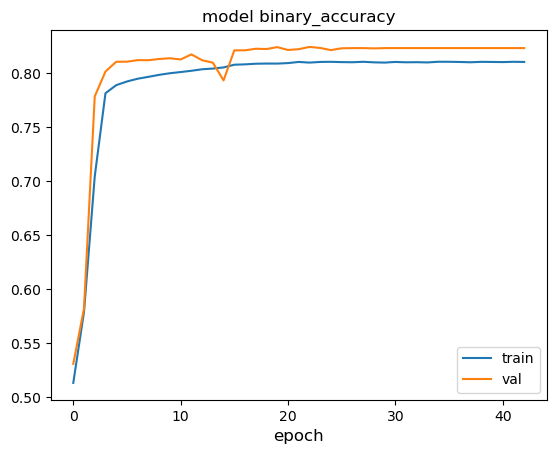

In [70]:
metric = ["binary_accuracy"]
plt.figure()
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model " + "binary_accuracy")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

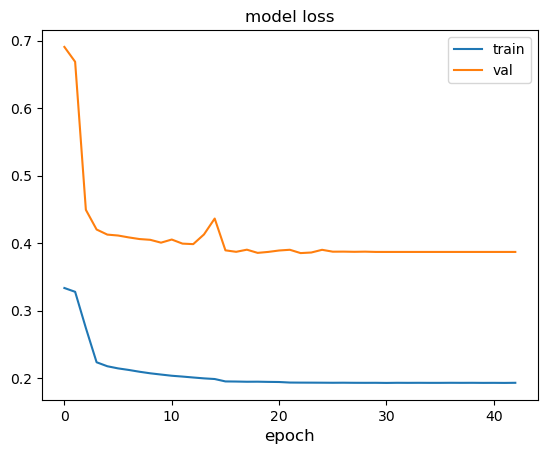

In [71]:
metric = ["loss"]
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model " + "loss")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

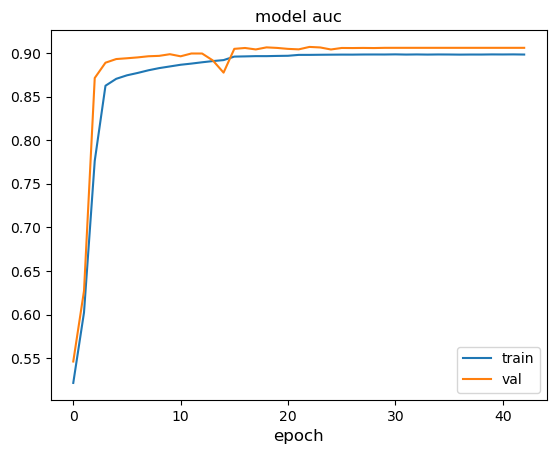

In [72]:
metric = ["tf.keras.metrics.AUC()"]
plt.figure()
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.title("model " + "auc")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

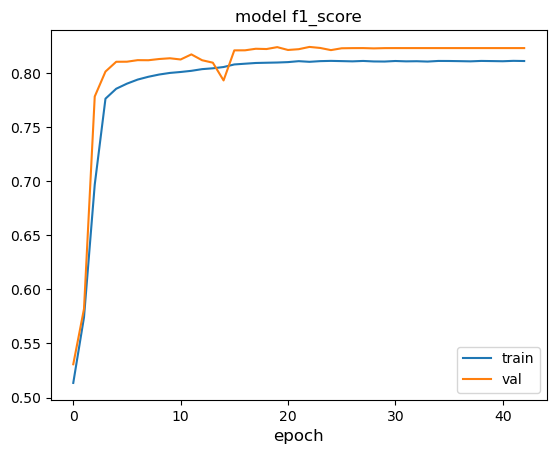

In [73]:
metric = ["f1_score"]
plt.figure()
plt.plot(history.history["f1_score"])
plt.plot(history.history["val_f1_score"])
plt.title("model " + "f1_score")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [74]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'binary_accuracy', 'f1_score', 'auc', 'specificity_at_sensitivity', 'sensitivity_at_specificity', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_binary_accuracy', 'val_f1_score', 'val_auc', 'val_specificity_at_sensitivity', 'val_sensitivity_at_specificity', 'val_recall', 'val_precision', 'lr'])


In [75]:
print(history.history['f1_score'])

[0.5134974122047424, 0.5741978883743286, 0.696795642375946, 0.776232898235321, 0.7854226231575012, 0.7901260852813721, 0.7938980460166931, 0.7964978814125061, 0.7985555529594421, 0.8000411987304688, 0.8009112477302551, 0.8019844889640808, 0.8035410642623901, 0.8043146729469299, 0.8054990172386169, 0.807877242565155, 0.8085641860961914, 0.8092313408851624, 0.8094568252563477, 0.809662938117981, 0.8100371956825256, 0.8109073042869568, 0.8103097677230835, 0.8109409809112549, 0.8111708164215088, 0.8109639286994934, 0.810734212398529, 0.8111081719398499, 0.8106476068496704, 0.8105640411376953, 0.8110599517822266, 0.8107374310493469, 0.8108555674552917, 0.8105387091636658, 0.8111040592193604, 0.8110724091529846, 0.8109233379364014, 0.8107432723045349, 0.8111287355422974, 0.8109908699989319, 0.8108375072479248, 0.8111995458602905, 0.811045229434967]


In [76]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 4

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(30, 20))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

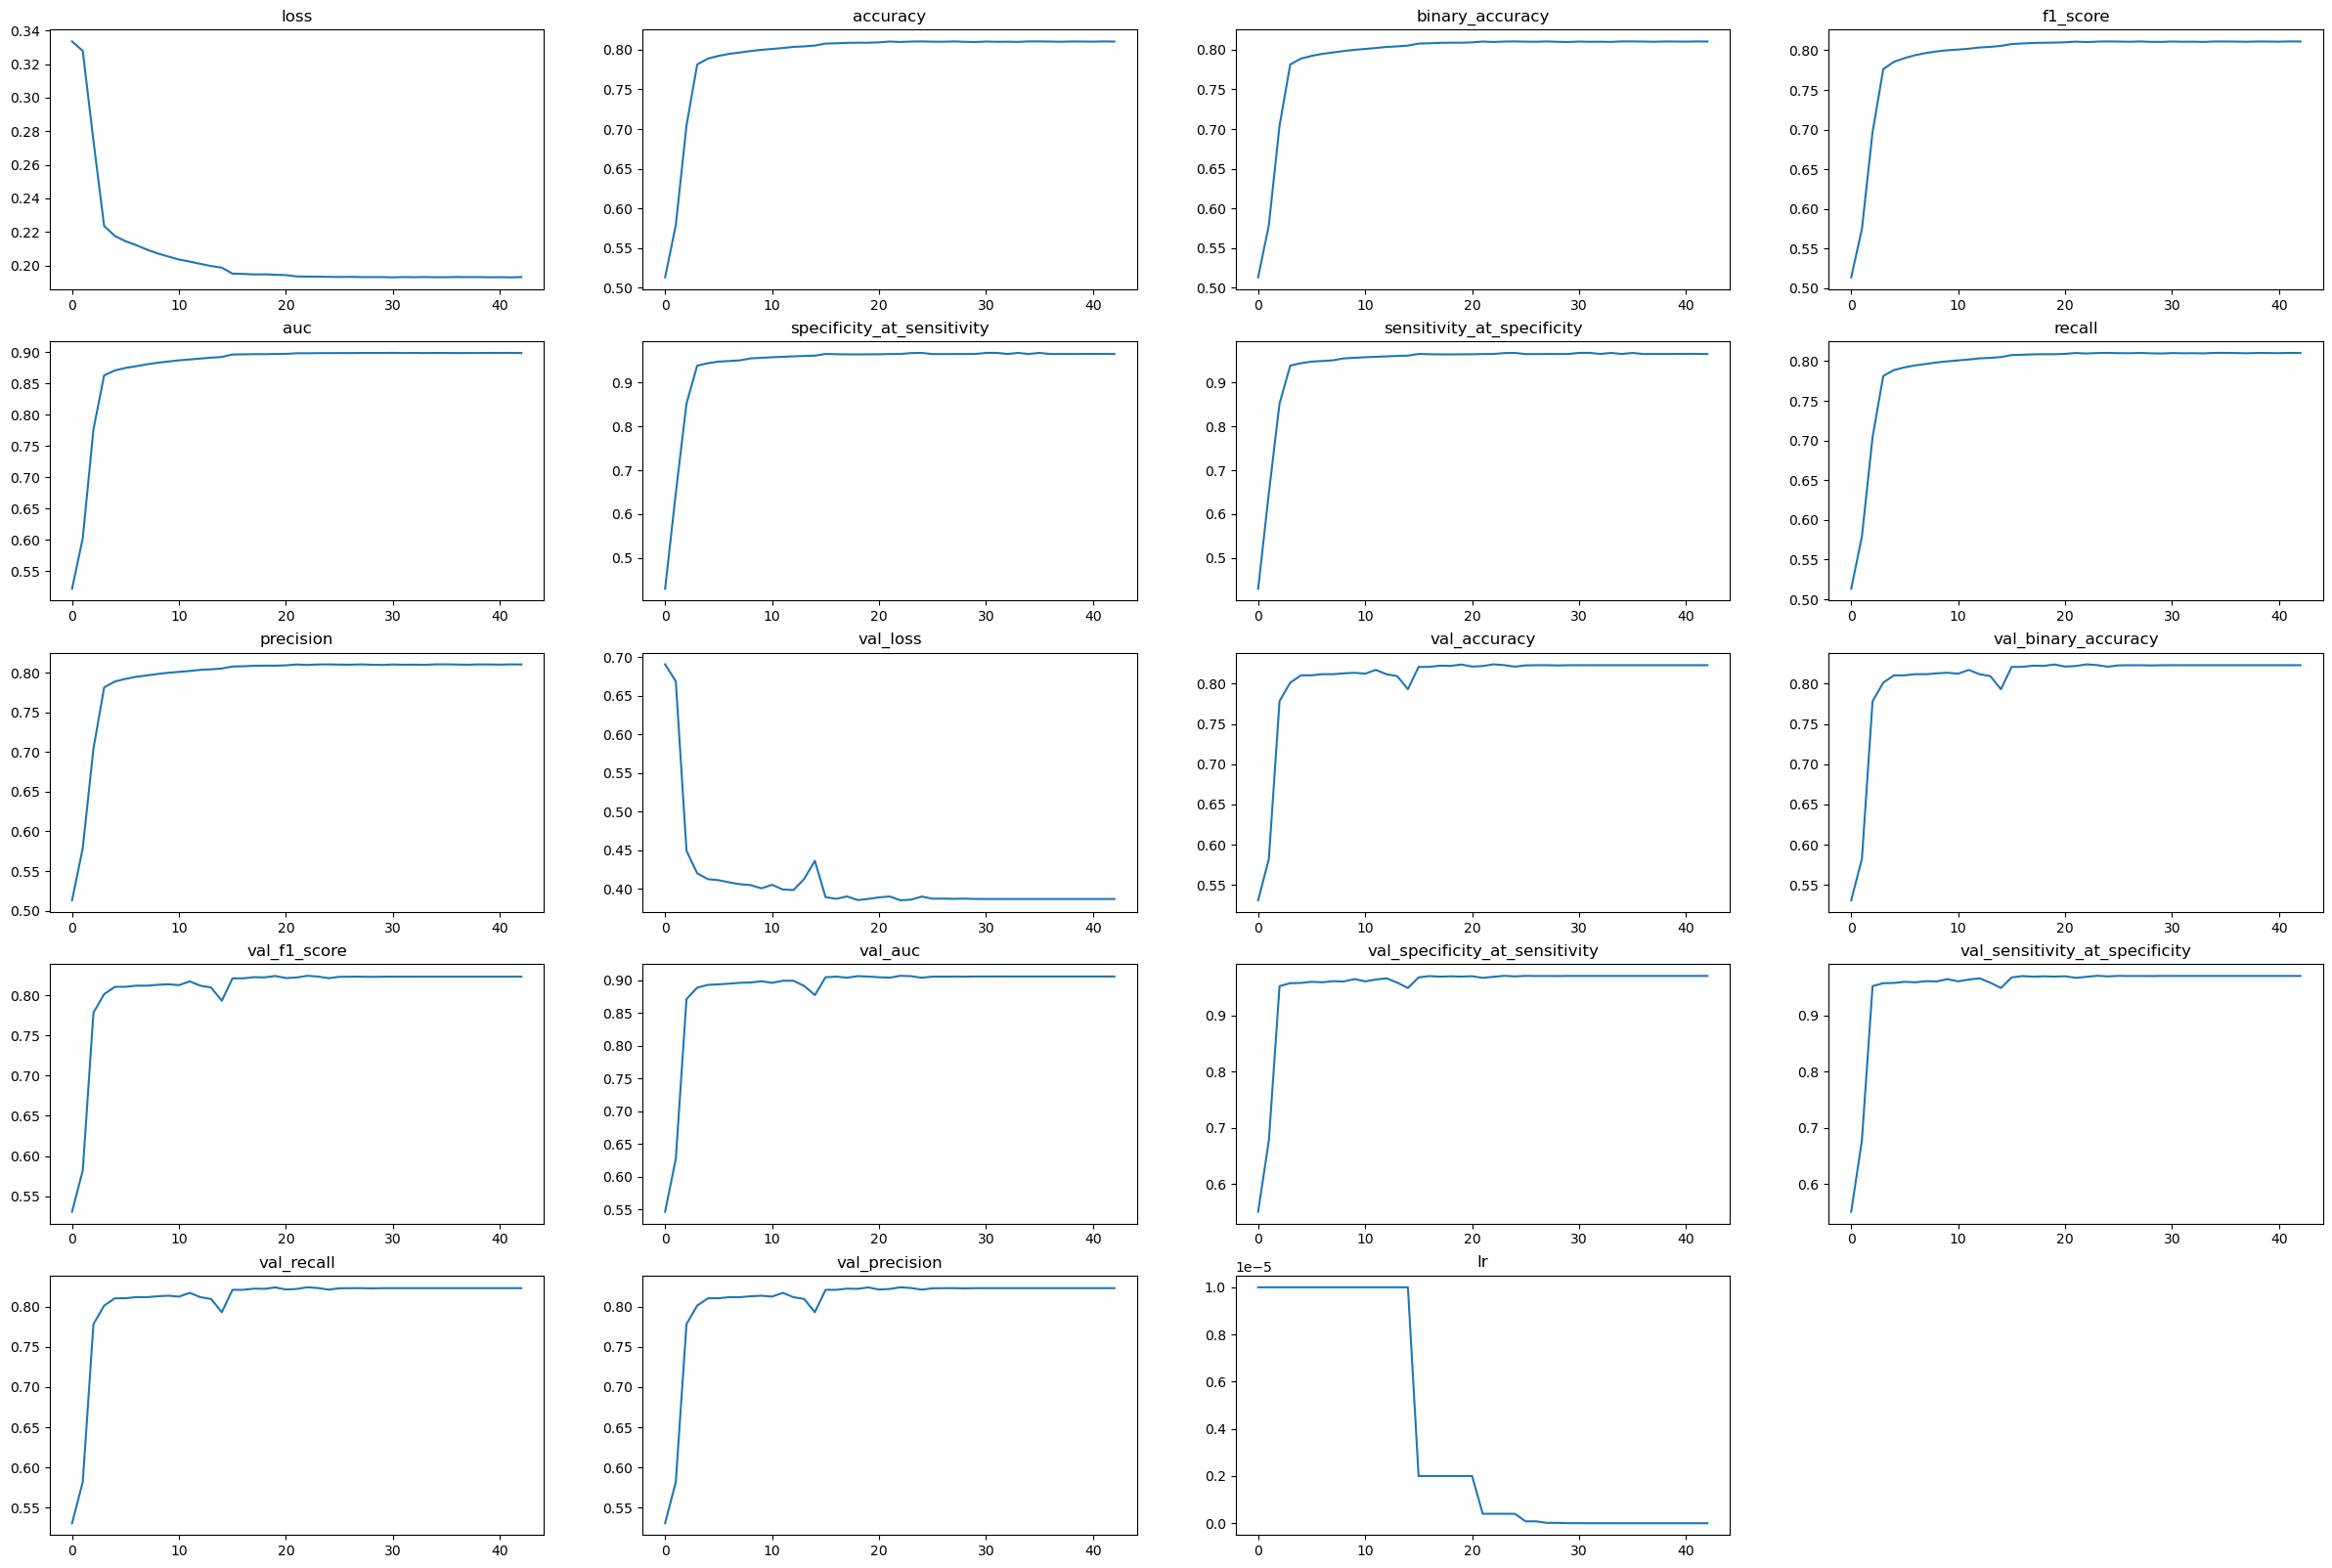

In [77]:
#print all metrics
plot_history_metrics(model.history)

In [78]:
model1 = keras.models.load_model(checkpoint_path)

model1.evaluate(x_test, y_test, verbose=1)

5178/5178 [==============================] - 166s 32ms/step - loss: 0.3868 - accuracy: 0.8219 - binary_accuracy: 0.8219 - f1_score: 0.8219 - auc: 0.9059 - specificity_at_sensitivity: 0.9694 - sensitivity_at_specificity: 0.9694 - recall: 0.8219 - precision: 0.8219


[0.3868415355682373,
 0.8218777775764465,
 0.8218777775764465,
 0.8218778371810913,
 0.9059038758277893,
 0.9693814516067505,
 0.9693814516067505,
 0.8218777775764465,
 0.8218777775764465]

In [79]:
x_test.shape

(165684, 360, 1)

In [80]:
#evaluating best model
# seems batch_size on testset does not effect test set performance
model.evaluate(x_test, y_test, batch_size=batch_size)

2589/2589 [==============================] - 157s 61ms/step - loss: 0.3868 - accuracy: 0.8219 - binary_accuracy: 0.8219 - f1_score: 0.8219 - auc: 0.9059 - specificity_at_sensitivity: 0.9694 - sensitivity_at_specificity: 0.9694 - recall: 0.8219 - precision: 0.8219


[0.38684192299842834,
 0.8218777775764465,
 0.8218777775764465,
 0.8218778371810913,
 0.905904233455658,
 0.9693814516067505,
 0.9693814516067505,
 0.8218777775764465,
 0.8218777775764465]

In [81]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=batch_size)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
#print("Generate predictions for 3 samples")
#predictions = model.predict(x_test[:3])
#print("predictions shape:", predictions.shape)

Evaluate on test data
2589/2589 [==============================] - 156s 60ms/step - loss: 0.3868 - accuracy: 0.8219 - binary_accuracy: 0.8219 - f1_score: 0.8219 - auc: 0.9059 - specificity_at_sensitivity: 0.9694 - sensitivity_at_specificity: 0.9694 - recall: 0.8219 - precision: 0.8219
test loss, test acc: [0.38684192299842834, 0.8218777775764465, 0.8218777775764465, 0.8218778371810913, 0.905904233455658, 0.9693814516067505, 0.9693814516067505, 0.8218777775764465, 0.8218777775764465]


In [82]:
#generate predication to draw a confusion matrix
predicted = model1.predict(x_test, batch_size=batch_size)

predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)

2589/2589 [==============================] - 146s 56ms/step


In [83]:
actual = tf.argmax(y_test, axis=1)

In [84]:
predicted

<tf.Tensor: shape=(165684,), dtype=int64, numpy=array([1, 0, 1, ..., 1, 1, 1], dtype=int64)>

In [85]:
actual

<tf.Tensor: shape=(165684,), dtype=int64, numpy=array([1, 0, 0, ..., 1, 1, 0], dtype=int64)>

In [86]:
labels=name_classes

In [87]:
labels

array([False, True], dtype=object)

In [88]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(actual, predicted) 

print(conf_mat)

[[49387 17817]
 [11695 86785]]


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

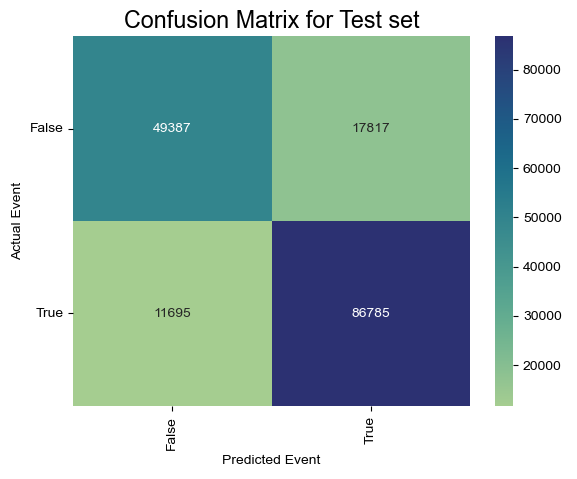

In [89]:
import seaborn as sns
cm = tf.math.confusion_matrix(actual, predicted)
ax = sns.heatmap(cm, annot=True, fmt='g',cmap="crest")
sns.set(rc={'figure.figsize':(12, 12)})
sns.set(font_scale=1.4)
ax.set_title('Confusion Matrix for Test set')
ax.set_xlabel('Predicted Event')
ax.set_ylabel('Actual Event')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [90]:
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

5178/5178 [==============================] - 151s 29ms/step
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     67204
           1       0.83      0.88      0.85     98480

    accuracy                           0.82    165684
   macro avg       0.82      0.81      0.81    165684
weighted avg       0.82      0.82      0.82    165684



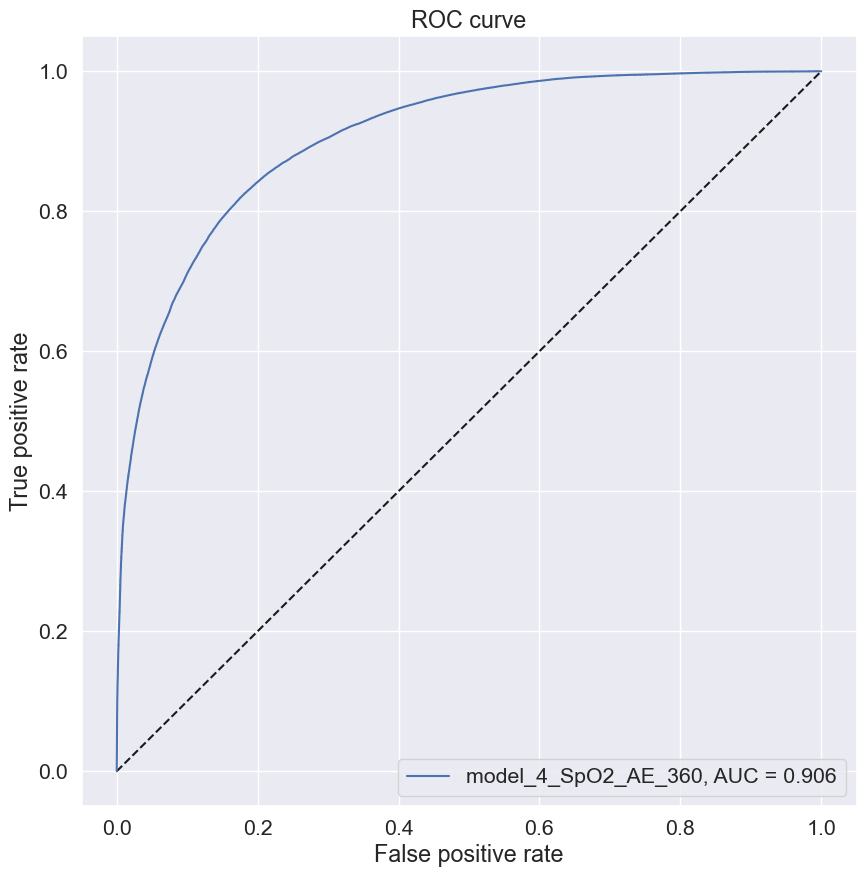

In [91]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')


y_pred = model.predict(x_test)
fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(tf.argmax(y_test, axis=1), y_pred))
plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format("model_4_SpO2_AE_360", auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [92]:
actual = tf.argmax(y_test, axis=1)

In [93]:
predicted

<tf.Tensor: shape=(165684,), dtype=int64, numpy=array([1, 0, 1, ..., 1, 1, 1], dtype=int64)>

In [94]:
actual


<tf.Tensor: shape=(165684,), dtype=int64, numpy=array([1, 0, 0, ..., 1, 1, 0], dtype=int64)>

In [95]:
labels=name_classes

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

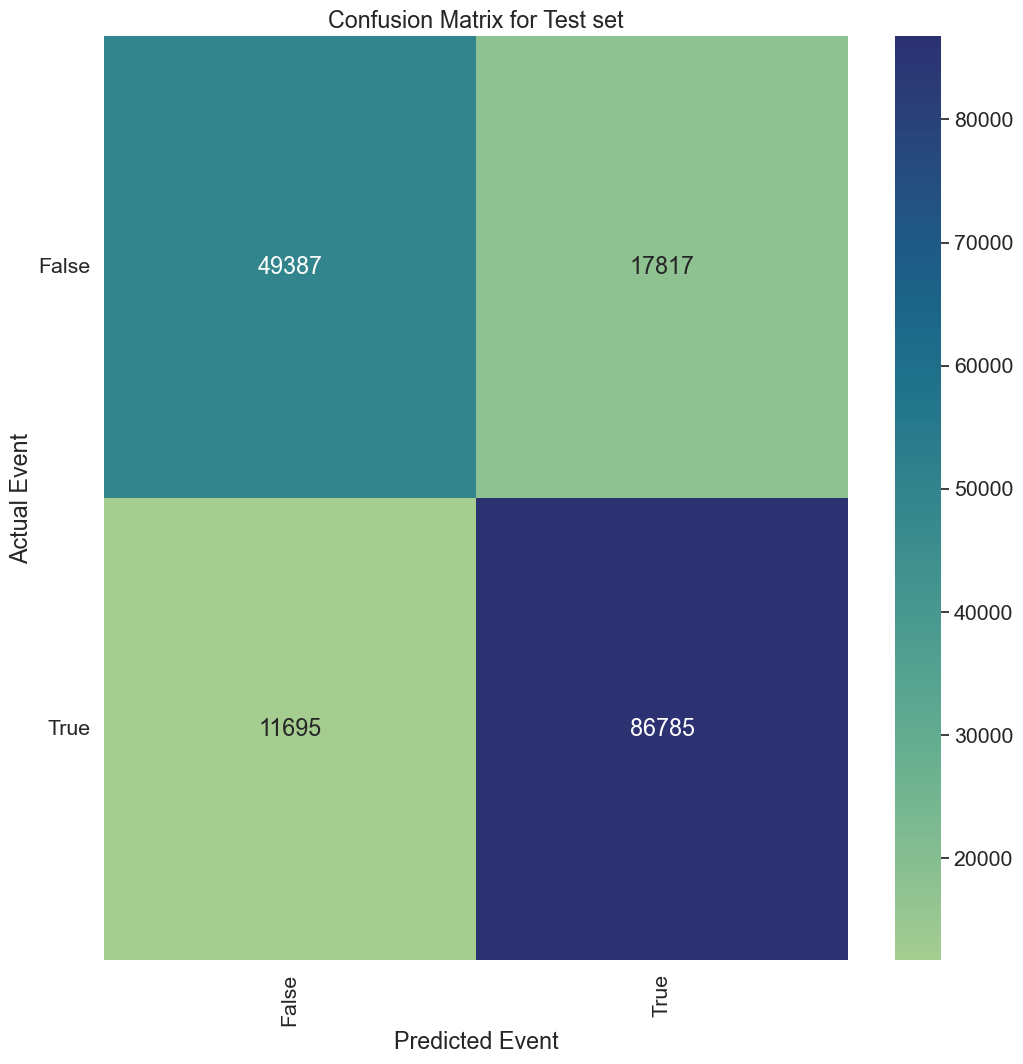

In [96]:
import seaborn as sns
cm = tf.math.confusion_matrix(actual, predicted)
ax = sns.heatmap(cm, annot=True, fmt='g',cmap="crest")
sns.set(rc={'figure.figsize':(10, 10)})
sns.set(font_scale=1.4)
ax.set_title('Confusion Matrix for Test set')
ax.set_xlabel('Predicted Event')
ax.set_ylabel('Actual Event')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [97]:
#list all CPUs and GPUs
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1043336917639788063
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5711593472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10429499483389563602
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [98]:
from sklearn.metrics import balanced_accuracy_score #this a reverse of the model accuracy, because we alredy weighted the dataset
bal_acc=balanced_accuracy_score(actual, predicted) #if you train the model without weighted considration, you can use this metric

In [99]:
bal_acc

0.8080633875488341

Indevidual Patient

In [100]:
import pickle

#path = "C:\\Users\\MalakAlmarshad\\Desktop\\premirly dataset for experiment\\ICUecgtiny.pkl"#for part of the dataset

path = "C:\\Users\\MalakAlmarshad\\Desktop\\premirly dataset for experiment\\ICUecgAll.pkl"



# Loading the dataset
with open(path, 'rb') as file:
    dataset = pickle.load(file)
    
display(dataset.head())

display(dataset.dtypes)

,patient,timestamp_datetime,SpO2(%),signal_ecg_ii,event,anomaly
0,1,2019-07-29 21:00:36,NaN,"[122, 121, 121, 120, 120, 122, 123, 124, 125, ...",NONE,False
1,1,2019-07-29 21:00:37,NaN,"[123, 124, 123, 123, 123, 122, 123, 123, 123, ...",NONE,False
2,1,2019-07-29 21:00:38,NaN,"[123, 124, 124, 124, 124, 124, 124, 124, 124, ...",NONE,False
3,1,2019-07-29 21:00:39,NaN,"[126, 126, 126, 126, 126, 125, 126, 126, 126, ...",NONE,False
4,1,2019-07-29 21:00:40,NaN,"[128, 127, 126, 125, 126, 127, 126, 125, 125, ...",NONE,False


patient                       object
timestamp_datetime    datetime64[ns]
SpO2(%)                      float64
signal_ecg_ii                 object
event                         object
anomaly                      boolean
dtype: object

In [1218]:
# condition mask
mask = dataframe['patient'] == "1"
 
# new dataframe with selected rows
df_15 = dataframe[mask]
 

print(df_15)

      patient  timestamp_datetime  SpO2(%)  \
0           1 2019-07-29 21:00:36      NaN   
1           1 2019-07-29 21:00:37      NaN   
2           1 2019-07-29 21:00:38      NaN   
3           1 2019-07-29 21:00:39      NaN   
4           1 2019-07-29 21:00:40      NaN   
...       ...                 ...      ...   
25173       1 2019-07-30 04:00:09     98.0   
25174       1 2019-07-30 04:00:10     98.0   
25175       1 2019-07-30 04:00:11     98.0   
25176       1 2019-07-30 04:00:12     98.0   
25177       1 2019-07-30 04:00:13     98.0   

                                           signal_ecg_ii event  anomaly  
0      [122, 121, 121, 120, 120, 122, 123, 124, 125, ...  NONE    False  
1      [123, 124, 123, 123, 123, 122, 123, 123, 123, ...  NONE    False  
2      [123, 124, 124, 124, 124, 124, 124, 124, 124, ...  NONE    False  
3      [126, 126, 126, 126, 126, 125, 126, 126, 126, ...  NONE    False  
4      [128, 127, 126, 125, 126, 127, 126, 125, 125, ...  NONE    False  
...

In [1219]:
df_15=df_15.dropna()

In [1220]:
df_15=df_15[['SpO2(%)', 'anomaly']]

In [1221]:
x_15 = df_15[['SpO2(%)']]
min_max_scaler_15 = preprocessing.MinMaxScaler()
x_scaled_15 = min_max_scaler_15.fit_transform(x_15)
dataset_15 = x_scaled_15

df_15['SpO2(%)']=dataset_15

In [1222]:
#Defining features (x) and labels (y)
targets_15 = df_15["anomaly"]
input_data_15 = df_15["SpO2(%)"]

In [1223]:
#Encode categorical features as a one-hot numeric array.
le_15 = preprocessing.LabelEncoder()  # Generates a look-up table
le_15.fit(targets_15)
targets_15 = le_15.transform(targets_15)

In [1224]:
x_seq_15=create_sequences(input_data_15)

C:\Users\MalakAlmarshad\AppData\Local\Temp\ipykernel_22128\948889072.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  output.append(values[i : (i + time_steps)])


In [1225]:
y_seq_15=create_sequences(targets_15)

In [1226]:
x_seq_15 = x_seq_15.reshape((x_seq_15.shape[0], x_seq_15.shape[1], 1))

In [1227]:
df1_15 = (y_seq_15 != 0).any(1).astype(int)
print (df1_15)

[0 0 0 ... 1 1 1]


In [1228]:
y_seq_15=df1_15

In [1229]:
y_seq_15=np.asarray(y_seq_15).astype(np.float32).reshape(-1, 1)

In [1230]:
y_seq_15 = keras.utils.to_categorical(y_seq_15)

In [1231]:
#patient # 15


model1.evaluate(x_seq_15, y_seq_15, verbose=1)

711/711 [==============================] - 20s 29ms/step - loss: 0.2757 - accuracy: 0.9052 - binary_accuracy: 0.9052 - f1_score: 0.9052 - auc: 0.9666 - specificity_at_sensitivity: 0.9927 - sensitivity_at_specificity: 0.9927 - recall: 0.9052 - precision: 0.9052


[0.2756792902946472,
 0.9051579833030701,
 0.9051579833030701,
 0.9051579833030701,
 0.9665770530700684,
 0.9927383065223694,
 0.9927383065223694,
 0.9051579833030701,
 0.9051579833030701]

In [1232]:
model.evaluate(x_seq_15,y_seq_15, batch_size=batch_size)

356/356 [==============================] - 18s 51ms/step - loss: 0.2757 - accuracy: 0.9052 - binary_accuracy: 0.9052 - f1_score: 0.9052 - auc: 0.9666 - specificity_at_sensitivity: 0.9927 - sensitivity_at_specificity: 0.9927 - recall: 0.9052 - precision: 0.9052


[0.27567824721336365,
 0.9051579833030701,
 0.9051579833030701,
 0.9051579833030701,
 0.966576337814331,
 0.9927383065223694,
 0.9927383065223694,
 0.9051579833030701,
 0.9051579833030701]

In [1233]:
#generate predication to draw a confusion matrix
predicted_15 = model.predict(x_seq_15, batch_size=batch_size)

predicted_15 = tf.concat(predicted_15, axis=0)
predicted_15 = tf.argmax(predicted_15, axis=1)

356/356 [==============================] - 17s 47ms/step


In [1234]:
actual_15 = tf.argmax(y_seq_15, axis=1)

In [1235]:
from sklearn.metrics import confusion_matrix
conf_mat_15 = confusion_matrix(actual_15, predicted_15) 

print(conf_mat_15)

[[ 1469   973]
 [ 1182 19098]]


[Text(0, 0.5, 'GT'), Text(0, 1.5, 'PD')]

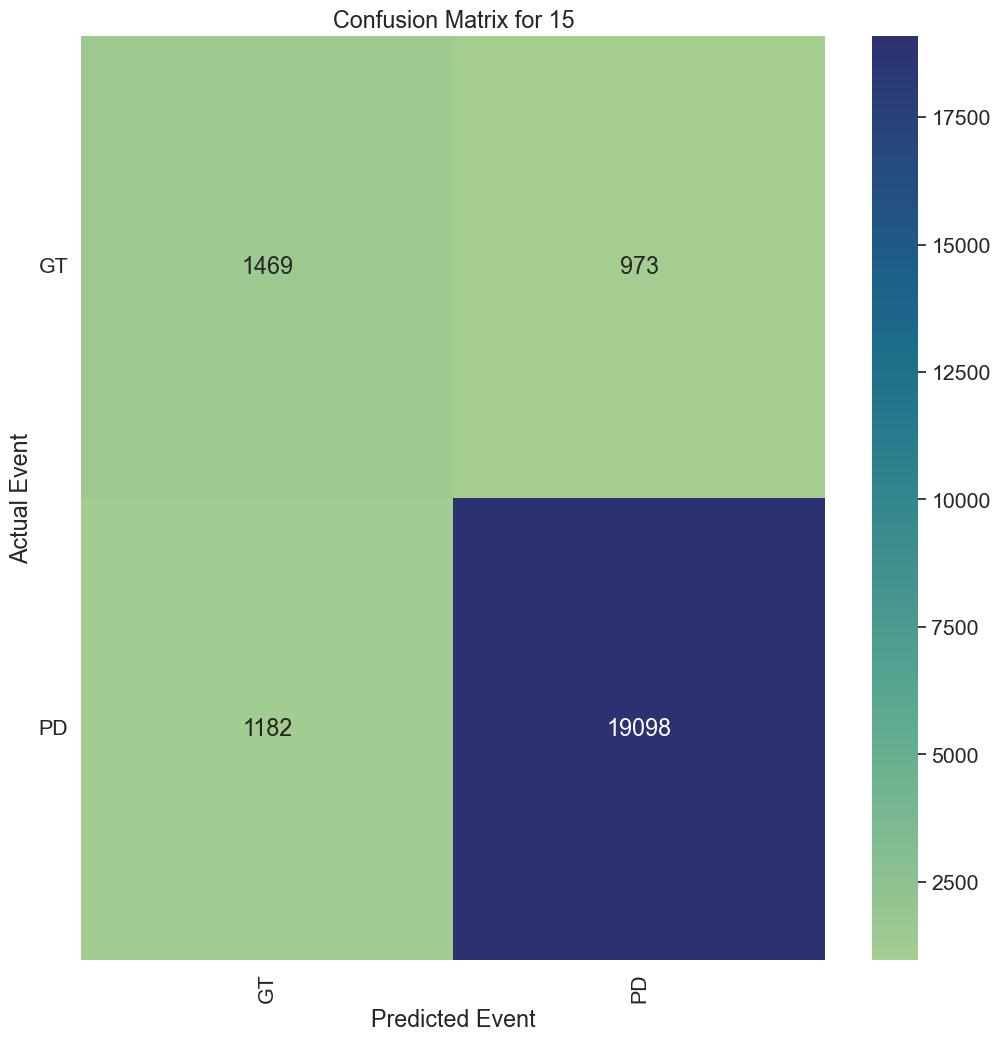

In [1236]:
import seaborn as sns
cm_15 = tf.math.confusion_matrix(actual_15, predicted_15)
ax = sns.heatmap(cm_15, annot=True, fmt='g',cmap="crest")
sns.set(rc={'figure.figsize':(12, 12)})
sns.set(font_scale=1.4)
ax.set_title('Confusion Matrix for 15')
ax.set_xlabel('Predicted Event')
ax.set_ylabel('Actual Event')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [1237]:
actual_15.shape

TensorShape([22722])

In [1238]:
actual_15

<tf.Tensor: shape=(22722,), dtype=int64, numpy=array([0, 0, 0, ..., 1, 1, 1], dtype=int64)>

In [1239]:
print(actual_15)

tf.Tensor([0 0 0 ... 1 1 1], shape=(22722,), dtype=int64)


In [1240]:
time_steps_vis=2880 #resoultion of event plot

def create_sequences_vis(values, time_steps=time_steps_vis):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [1241]:
actual_15v2=actual_15
predicted_15v2=predicted_15

In [1242]:
actual_15v2=create_sequences_vis(actual_15)
predicted_15v2=create_sequences_vis(predicted_15)

In [1243]:
actual_15v2

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

In [1244]:
# unique, counts = np.unique(actual_15v2, return_counts=True)
# unique1, counts1 = np.unique(minvalue_series, return_counts=True)

In [1245]:

# dict(zip(unique, counts))

In [1246]:
# dict(zip(unique1, counts1))

In [1247]:
minvalue_series_actual_15v2 = actual_15v2.min(axis = 1)
minvalue_series_predicted_15v2=predicted_15v2.min(axis = 1)

In [1248]:
minvalue_series_actual_15v2.min()

0

In [1249]:
minvalue_series_predicted_15v2.min()

0

In [1250]:
minvalue_series_actual_15v2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [1251]:
minvalue_series_predicted_15v2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [1252]:
# arr =actual_15v2
# parr=predicted_15v2

In [1253]:
# print( arr[1:] )
# print(parr[1:])

In [1254]:
# print( arr[:-1] )
# print( parr[:-1] )

In [1255]:
# print( arr[1:] != arr[:-1] )

In [1256]:
# arr2= arr[1:] != arr[:-1]
# parr2= parr[1:] != parr[:-1]

In [1257]:
# out = np.where(arr2==True)[0] + 1
# print( out )
# pout = np.where(parr2==True)[0] + 1
# print( pout )

In [1258]:
# actualD=np.zeros_like(arr2)
# predictedD=np.zeros_like(parr2)

In [1259]:
#actualD[1667]

In [1260]:
# actualD[out]=1
# predictedD[pout]=1

In [1261]:
# spike_15=actualD[:].numpy()
# spike2_15=predicted_15[:].numpy()

# spiky_15=tf.where(spike_15).numpy().tolist()
# spiky2_15=tf.where(spike2_15).numpy().tolist()



In [1262]:
predicted_15

<tf.Tensor: shape=(22722,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int64)>

In [1263]:
actualD

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [1264]:
minvalue_series_actual_15v2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [1265]:
spike_15=minvalue_series_actual_15v2
spike2_15=minvalue_series_predicted_15v2

spike_15=tf.where(spike_15).numpy().tolist()
spike2_15=tf.where(spike2_15).numpy().tolist()

In [1266]:
# spike_15=actual_15[:].numpy()
# spike2_15=predicted_15[:].numpy()

# spiky_15=tf.where(spike_15).numpy().tolist()
# spiky2_15=tf.where(spike2_15).numpy().tolist()



In [1267]:
# spiky_15

In [1268]:
flat_list_15 = [item for sublist in spike_15 for item in sublist]
spike_15 =flat_list_15
flat_list2_15 = [item for sublist in spike2_15 for item in sublist]
spike2_15 =flat_list2_15

In [1269]:
spike2_15

[738,
 739,
 740,
 741,
 742,
 743,
 744,
 745,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 757,
 758,
 759,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 767,
 768,
 769,
 770,
 771,
 772,
 773,
 774,
 775,
 776,
 777,
 778,
 779,
 780,
 781,
 782,
 783,
 784,
 785,
 786,
 787,
 788,
 789,
 790,
 791,
 792,
 793,
 794,
 795,
 796,
 797,
 798,
 799,
 800,
 801,
 802,
 803,
 804,
 805,
 806,
 807,
 808,
 809,
 810,
 811,
 812,
 813,
 814,
 815,
 816,
 817,
 818,
 819,
 820,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 828,
 829,
 830,
 831,
 832,
 833,
 834,
 835,
 836,
 837,
 838,
 839,
 840,
 841,
 842,
 843,
 844,
 845,
 846,
 847,
 848,
 849,
 850,
 851,
 852,
 853,
 854,
 855,
 856,
 857,
 858,
 859,
 860,
 861,
 862,
 863,
 864,
 865,
 866,
 867,
 868,
 869,
 870,
 871,
 872,
 873,
 874,
 875,
 876,
 877,
 878,
 879,
 880,
 881,
 882,
 883,
 884,
 885,
 886,
 887,
 888,
 889,
 890,
 891,
 892,
 893,
 894,
 895,
 896,
 897,
 898,
 899,
 900,
 901,
 902,
 903,
 904

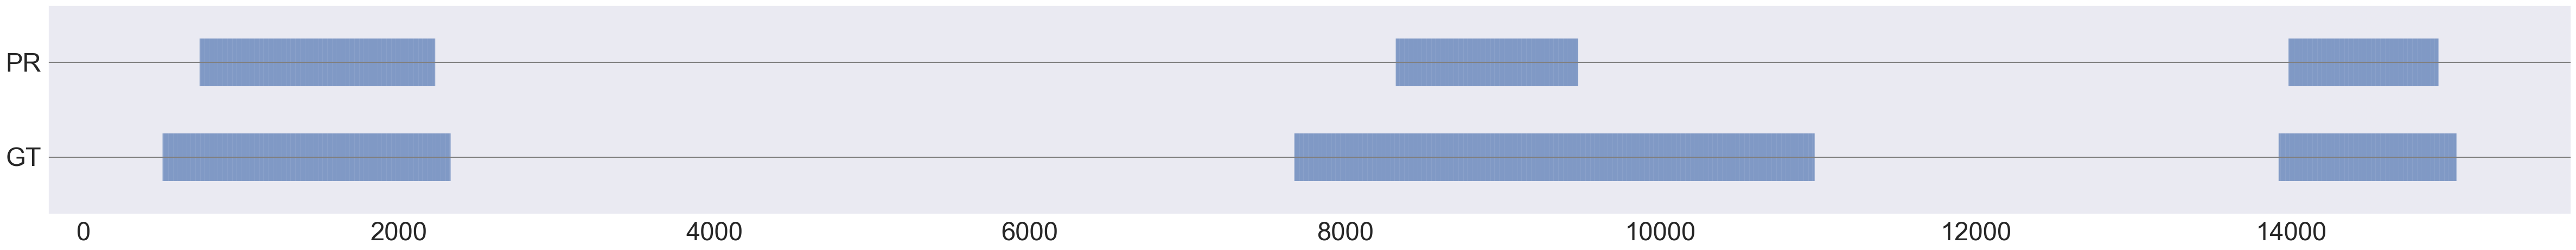

In [1270]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt1

plt.figure(figsize=(60,5))

plt1.eventplot(spike2_15, 
              orientation = 'horizontal',
              linelengths = 0.01,
              lineoffsets=[.02],
              lw=0.2
              )

plt1.eventplot(spike_15, 
              orientation = 'horizontal',
              linelengths = 0.01,
              lineoffsets=[0],
              lw=0.2, 
              )

plt1.axhline(y=0.02, color='gray', linestyle='-')
plt1.axhline(y=0, color='gray', linestyle='-')

labels=['GT', 'PD']
plt1.yticks(np.arange(0, 0,5))  # Set label locations.
plt1.yticks([0, .02], labels=['GT', 'PR'], fontsize=34)  # Set text labels and properties.
plt1.xticks( fontsize=34)  # Set text labels and properties.

plt.grid(False)


plt1.show()

In [1271]:
#end of paitent_15

In [1116]:
spike=actual[:30].numpy()
spike2=predicted[:30].numpy()

In [1117]:
spiky=tf.where(spike).numpy().tolist()
spiky2=tf.where(spike2).numpy().tolist()

In [1118]:
flat_list = [item for sublist in spiky for item in sublist]
spiky =flat_list
flat_list2 = [item for sublist in spiky2 for item in sublist]
spiky2 =flat_list2

In [1119]:
predictedTrain = model.predict(x_test, batch_size=batch_size)

predictedTrain = tf.concat(predictedTrain, axis=0)
predictedTrain = tf.argmax(predictedTrain, axis=1)

2589/2589 [==============================] - 136s 53ms/step


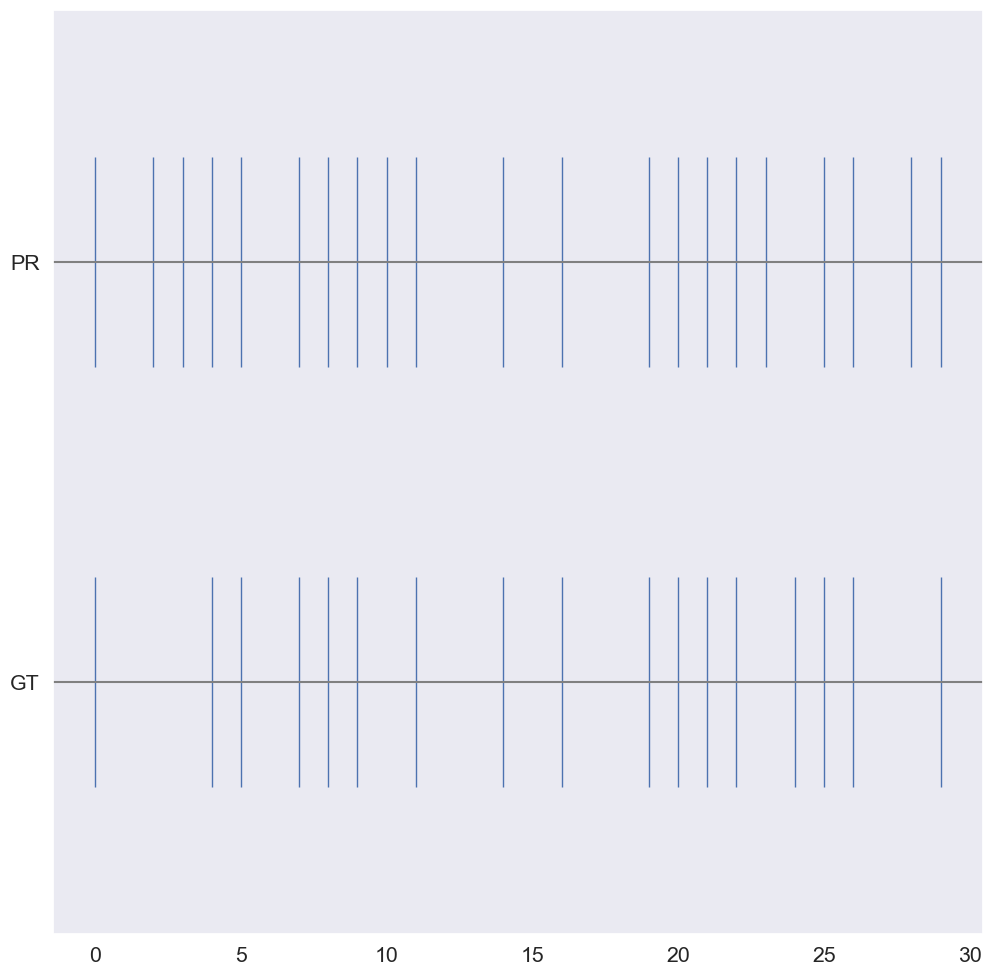

In [1120]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt1

plt1.eventplot(spiky2, 
              orientation = 'horizontal',
              linelengths = 0.01,
              lineoffsets=[.02],
              lw=1
              )

plt1.eventplot(spiky, 
              orientation = 'horizontal',
              linelengths = 0.01, 
              lineoffsets=[0],
              lw=1
              )
plt1.axhline(y=0.02, color='gray', linestyle='-')
plt1.axhline(y=0, color='gray', linestyle='-')
labels=['GT', 'PD']
plt1.yticks(np.arange(0, 0,5))  # Set label locations.
plt1.yticks([0, .02], labels=['GT', 'PR'])  # Set text labels and properties.
plt.grid(False)


plt1.show()

In [1121]:
actualtrain = tf.argmax(y_train, axis=1)

In [1122]:
now = datetime.now()
current_end_time = now.strftime("%Y-%m-%d %H:%M:%S")
current_end_time

'2023-07-14 06:08:06'